In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from functions import *
from helpers import *
from proj1_helpers import *
from costs import *
from data_preprocessing import *

%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
# TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
print("loading of the data : done")

loading of the data : done


In [3]:
def split_data(x, y, ratio_of_training):
    """split the dataset based on the split ratio."""
    p = np.random.permutation(np.arange(y.shape[0]))
    n = int(y.shape[0] * ratio_of_training)
    return  x[p][:n], x[p][n:], y[p][:n], y[p][n:]

# Understand The Data

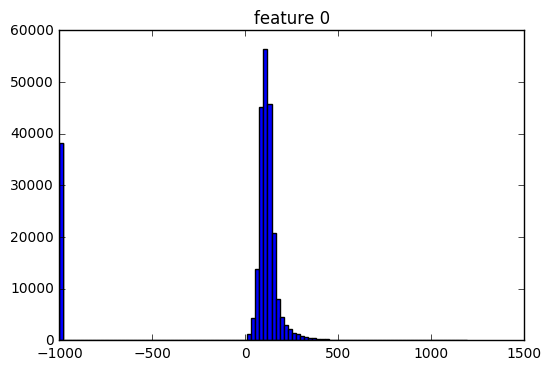

In [4]:
# Time Visualization

from ipywidgets import IntSlider, interact
from IPython.display import display

def plot_hist(tx, i, transformation=None):
    plt.figure()
    if transformation is None:
        plt.hist(tx[:, i], bins=100)
    else:
        plt.hist(transformation(tx[:, i]), bins=100)
    plt.title("feature %i" % i)
    plt.show()

interact(lambda x:plot_hist(tX, x), x=IntSlider(min=0, max=29))
plt.show()

    Good Features                   : [7, 10, 14, 15, 17, 18, 20
    Suffering from outlier          : [3, 8, 19, 23, 26, 29]
    Suffering from outlier (skewed) : [1, 2, 5, 9, 13, 16, 21]
    missing values                  : [0, 4, 6, 12, 23, 24, 25, 26, 27, 28]
    categorical                     : [11, 12, 22]

## Devide Features

In [233]:
Features_Good            = [7, 10, 14, 15, 17, 18, 20]
Features_with_outlier    = [3, 8, 19, 23, 26, 29]
Features_skewed          = [1, 2, 5, 9, 13, 16, 21]
Features_missing_entry   = [0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28]
Features_categorical     = [11, 12, 22]
Features_non_categorical = [x for x in range(30) if x not in Features_categorical]
Features_using_log       = np.union1d(Features_with_outlier, Features_skewed)

## Devide Datapoints

In [234]:
completeness_status_tX = np.sum(tX == -999, axis=1)
non_missing_tX         = tX[completeness_status_tX==0, :]
missing_tX             = tX[completeness_status_tX!=0, :]

In [351]:
filled_tX_median     = fill_na(tX, np.median)
filled_tX_mean       = fill_na(tX, np.mean)
missing_indicator_tX = missing_indicator(tX)
log_tX               = logs_of_features(filled_tX_median, Features_using_log)
decomposed_tX        = decompose_categorical_features(filled_tX_median)
inverse_tX           = inver_terms(filled_tX_median, Features_using_log)

In [352]:
mixed_tX = mixed_features(filled_tX_median, Features_non_categorical)
mixed_tX.shape

(250000, 351)

In [9]:
Features_denominate = Features_using_log
Features_numerator  = [x for x in Features_non_categorical if x not in Features_denominate]

def mixed_inverse_features(tx, features_denominate, features_numerator):
    foo = np.zeros(tx.shape[0])
    for i in features_denominate:
        for j in features_numerator:
            foo = np.c_[foo, tx[:, i]/(tx[:, j] + 1e-8)]
            
    return foo[:, 1:]

mixed_invese_tX = mixed_inverse_features(filled_tX_median, Features_denominate, Features_numerator)

In [10]:
mixed_invese_tX.shape

(250000, 182)

# low degree but more features

In [408]:
# For non categorical features, build polynomials
degree = 3
poly_tX = build_polynomial_without_mixed_term(filled_tX_median[:, Features_non_categorical], degree=degree)
log_poly_tX = build_polynomial_without_mixed_term(log_tX, degree=degree)
# inv_poly_tX = build_polynomial_without_mixed_term(inverse_tX, degree=degree)

# Build a design matrix
design_matrix = np.c_[poly_tX, decomposed_tX, missing_indicator_tX, log_poly_tX, mixed_tX]
tX9, mean_x, std_x = standardize(design_matrix)
training_ratio = 0.9
y9 = transform_y(y)
train_tX9, cv_tX9, train_y9, cv_y9 = split_data(tX9, y9, training_ratio)
cv_tX9.shape

(25000, 478)

#### Find out correlated columns

In [197]:
def detect_corr(tx):
    print (tx.shape[1])
    if (tx.shape[0] < 20000):
        print (np.linalg.matrix_rank(tx))

In [386]:
log_poly_tX.shape

(250000, 39)

In [405]:
detect_corr(tX9[:10000, :])

438
437


#### Normal

In [457]:
def cross_validation_var(y, tx, K, func, seed, fpred, faccuracy, max_fold):
    """Cross validation (varied version)
    
    When the datasets are large and we want to train on a small subset of data,
    and validate them on the rest of datasets. We will first divide the the data
    into K parts and train on only one of them, then test them on the rest K-1
    parts.
    
    input:
        y   : 1-D array (processed).
        tx  : 2-D design matrix (processed).
        K   : K-folded cross validation
        func: function which takes (y, tx) as argument
        seed: random seed
        
        fpred: prediction function
        faccuracy: function for calculating accuracy
        
    return:
        ave_acc : averaged accuracy
    """
    import time
    
    np.random.seed(seed)
    n = len(y)
    tr_size = n // K
    perm  = np.random.permutation(np.arange(n)).reshape(K, tr_size)
    idx = np.ma.array(np.arange(K), mask=False)
                                    
    def get_index():
        i = 0
        while i < K:
            idx.mask[i] = True
            yield perm[i], perm[idx].flatten()
            idx.mask[i] = False
            i = i + 1
    
    tr_accs = []
    cv_accs = []
    for i, (tr_idx, cv_idx) in zip(np.arange(max_fold), get_index()):
        start   = time.time()

        w, cost = func(y[tr_idx], tx[tr_idx, :])
        end     = time.time()
        print ("Time for {i:2}th cross validation = {t:3.6}s".format(i=i, t=end-start))
        
        pred_y  = fpred(tx[cv_idx], w)
        cv_acc  = faccuracy(pred_y, y[cv_idx])
        pred_y  = fpred(tx[tr_idx], w)
        tr_acc  = faccuracy(pred_y, y[tr_idx])
        
        print ("Training Accuracy         = {a:6.10}".format(a=tr_acc))
        print ("Cross Validation Accuracy = {a:6.10}".format(a=cv_acc))
        tr_accs.append(tr_acc)
        cv_accs.append(cv_acc)
        
    return tr_accs, cv_accs

In [ ]:
set_up_f = lambda y, tx : logistic_AGDR(y, tx, gamma=1e-6, 
               max_iters = 10000, lambda_=0.5, regularizor=regularizor_lasso)

cross_validation_var(y9, tX9, 
                     K=25, 
                     func=set_up_f, 
                     seed=3, 
                     fpred=predict_cv,
                     faccuracy=accuracy,
                     max_fold=1
                    )

In [441]:
set_up_f = lambda y, tx : logistic_AGDR(y, tx, gamma=1e-6, 
               max_iters = 10000, lambda_=0.5, regularizor=regularizor_lasso)

def predict_cv(tx, w):
    return 1 * ((tx @ w) > 0)

cross_validation_var(y9, tX9, K=25, 
                     func=set_up_f, 
                     seed=3,
                     fpred=predict_cv, 
                     faccuracy=accuracy, 
                     max_fold=1)

Losgistic Regression(       0/10000): loss= 6821.17151835445
Losgistic Regression(     100/10000): loss= 4544.61276932469
Losgistic Regression(     200/10000): loss= 4270.87902890875
Losgistic Regression(     300/10000): loss= 4136.31849876117
Losgistic Regression(     400/10000): loss= 4050.29705059181
Losgistic Regression(     500/10000): loss= 3988.49090212743
Losgistic Regression(     600/10000): loss= 3943.35903686592
Losgistic Regression(     700/10000): loss= 3909.81930111496
Losgistic Regression(     800/10000): loss= 3883.24686723897
Losgistic Regression(     900/10000): loss= 3861.92395576994
Losgistic Regression(    1000/10000): loss= 3844.11086419099
Losgistic Regression(    1100/10000): loss= 3828.55174370073
Losgistic Regression(    1200/10000): loss= 3814.97516728427
Losgistic Regression(    1300/10000): loss= 3803.32463602277
Losgistic Regression(    1400/10000): loss= 3793.47852120653
Losgistic Regression(    1500/10000): loss= 3785.77659681995
Losgistic Regression(   

0.81420400000000004

In [472]:
def training(n, lambda_):
    set_up_f = lambda y, tx : logistic_AGDR(y, tx, gamma=1e-6, 
                   max_iters = 10000, lambda_=lambda_, regularizor=regularizor_lasso)

    return cross_validation_var(y9, tX9, K=(250000//n), 
                         func=set_up_f, 
                         seed=3,
                         fpred=predict_cv, 
                         faccuracy=accuracy, 
                         max_fold=5)

#### 50000

In [478]:
accu_50000 = []
for lambda_ in np.logspace(-3, 1.5,num=6,base=4):
    tmp = training(50000, lambda_)
    print("***************", tmp)
    accu_50000.append(tmp)

accu_50000

Losgistic Regression(       0/10000): loss= 32495.5055050499
Losgistic Regression(     100/10000): loss= 21564.8229086324
Losgistic Regression(     200/10000): loss= 20662.8263215795
Losgistic Regression(     300/10000): loss= 20224.9277174388
Losgistic Regression(     400/10000): loss= 19944.7098363013
Losgistic Regression(     500/10000): loss= 19817.4213630915
Losgistic Regression(     600/10000): loss= 19733.4073985364
Losgistic Regression(     700/10000): loss= 19680.1023139437
Losgistic Regression(     800/10000): loss= 19630.6836645785
Losgistic Regression(     900/10000): loss= 19601.2017266897
Losgistic Regression(    1000/10000): loss= 19574.9996255812
Losgistic Regression(    1100/10000): loss= 19543.7313412869
Losgistic Regression(    1200/10000): loss= 19519.4291790914
Losgistic Regression(    1300/10000): loss= 19499.7704212502
Losgistic Regression(    1400/10000): loss= 19481.2780787485
Losgistic Regression(    1500/10000): loss= 19466.3310751705
Losgistic Regression(   

KeyboardInterrupt: 

#### 25000

In [477]:
accu_25000 = []
for lambda_ in np.logspace(-3, 1.5,num=6,base=4):
    tmp = training(25000, lambda_)
    print("***************", tmp)
    accu_25000.append(tmp)

accu_25000

Losgistic Regression(       0/10000): loss= 16721.0280439384
Losgistic Regression(     100/10000): loss= 10932.1251833644
Losgistic Regression(     200/10000): loss= 10407.2173779291
Losgistic Regression(     300/10000): loss= 10146.086705963
Losgistic Regression(     400/10000): loss= 9983.54157283347
Losgistic Regression(     500/10000): loss= 9871.30073461271
Losgistic Regression(     600/10000): loss= 9784.79324806552
Losgistic Regression(     700/10000): loss= 9713.16026138604
Losgistic Regression(     800/10000): loss= 9661.16929158904
Losgistic Regression(     900/10000): loss= 9626.34455776342
Losgistic Regression(    1000/10000): loss= 9598.86646649527
Losgistic Regression(    1100/10000): loss= 9579.13566108009
Losgistic Regression(    1200/10000): loss= 9563.33988045476
Losgistic Regression(    1300/10000): loss= 9551.09499138008
Losgistic Regression(    1400/10000): loss= 9540.77399486591
Losgistic Regression(    1500/10000): loss= 9527.90641571044
Losgistic Regression(    

[([0.83272000000000002,
   0.83067999999999997,
   0.82776000000000005,
   0.83223999999999998,
   0.82672000000000001],
  [0.82135199999999997,
   0.82273200000000002,
   0.823048,
   0.82201199999999996,
   0.82067999999999997]),
 ([0.83264000000000005,
   0.83055999999999996,
   0.82779999999999998,
   0.83252000000000004,
   0.82672000000000001],
  [0.82141200000000003,
   0.822716,
   0.82310399999999995,
   0.82216,
   0.82072000000000001]),
 ([0.83243999999999996,
   0.83072000000000001,
   0.82804,
   0.83252000000000004,
   0.82667999999999997],
  [0.821492,
   0.82279999999999998,
   0.82308800000000004,
   0.82211199999999995,
   0.82077999999999995]),
 ([0.83248,
   0.82984000000000002,
   0.82784000000000002,
   0.83099999999999996,
   0.82632000000000005],
  [0.821712,
   0.82266799999999995,
   0.82337199999999999,
   0.82179199999999997,
   0.820936]),
 ([0.82991999999999999,
   0.82904,
   0.82604,
   0.82876000000000005,
   0.82411999999999996],
  [0.82194400000000001

#### 10000

In [476]:
accu_10000 = []
for lambda_ in np.logspace(-3, 1.5,num=6,base=4):
    tmp = training(10000, lambda_)
    print("***************", tmp)
    accu_10000.append(tmp)

accu_10000

Losgistic Regression(       0/10000): loss= 6821.09725390924
Losgistic Regression(     100/10000): loss= 4536.47032779892
Losgistic Regression(     200/10000): loss= 4256.02807380162
Losgistic Regression(     300/10000): loss= 4115.29060027381
Losgistic Regression(     400/10000): loss= 4023.8808452216
Losgistic Regression(     500/10000): loss= 3957.02846304881
Losgistic Regression(     600/10000): loss= 3907.54728747435
Losgistic Regression(     700/10000): loss= 3870.04094953132
Losgistic Regression(     800/10000): loss= 3839.50710073522
Losgistic Regression(     900/10000): loss= 3814.22003875712
Losgistic Regression(    1000/10000): loss= 3792.47865657709
Losgistic Regression(    1100/10000): loss= 3773.58087112654
Losgistic Regression(    1200/10000): loss= 3756.89606693645
Losgistic Regression(    1300/10000): loss= 3742.30381021611
Losgistic Regression(    1400/10000): loss= 3729.82165615005
Losgistic Regression(    1500/10000): loss= 3719.83789594026
Losgistic Regression(    

[([0.84109999999999996,
   0.84240000000000004,
   0.84740000000000004,
   0.84499999999999997,
   0.83530000000000004],
  [0.81363200000000002,
   0.81584000000000001,
   0.81413999999999997,
   0.81413999999999997,
   0.81575200000000003]),
 ([0.84050000000000002,
   0.8417,
   0.84689999999999999,
   0.84509999999999996,
   0.83550000000000002],
  [0.81368399999999996,
   0.81589999999999996,
   0.81435599999999997,
   0.81452400000000003,
   0.81611199999999995]),
 ([0.83950000000000002,
   0.84160000000000001,
   0.84689999999999999,
   0.84470000000000001,
   0.83479999999999999],
  [0.81397600000000003,
   0.81662800000000002,
   0.81508000000000003,
   0.81530800000000003,
   0.81635199999999997]),
 ([0.83799999999999997,
   0.83860000000000001,
   0.84150000000000003,
   0.84130000000000005,
   0.8337],
  [0.81418800000000002,
   0.81781599999999999,
   0.81410800000000005,
   0.81677599999999995,
   0.81650800000000001]),
 ([0.83120000000000005,
   0.8347,
   0.83979999999999

#### 5000

In [475]:
accu_5000 = []
for lambda_ in np.logspace(-3, 1.5,num=6,base=4):
    tmp = training(5000, lambda_)
    print("***************", tmp)
    accu_5000.append(tmp)

accu_5000

Losgistic Regression(       0/10000): loss= 3436.25369024268
Losgistic Regression(     100/10000): loss= 2335.38408481608
Losgistic Regression(     200/10000): loss= 2120.8244973092
Losgistic Regression(     300/10000): loss= 2038.86023994235
Losgistic Regression(     400/10000): loss= 1982.2365087908
Losgistic Regression(     500/10000): loss= 1939.79190706255
Losgistic Regression(     600/10000): loss= 1906.11170764866
Losgistic Regression(     700/10000): loss= 1878.43608128396
Losgistic Regression(     800/10000): loss= 1855.55657337835
Losgistic Regression(     900/10000): loss= 1836.53791910732
Losgistic Regression(    1000/10000): loss= 1820.35362213278
Losgistic Regression(    1100/10000): loss= 1806.22017349487
Losgistic Regression(    1200/10000): loss= 1793.66089585403
Losgistic Regression(    1300/10000): loss= 1782.3396391158
Losgistic Regression(    1400/10000): loss= 1772.28250224786
Losgistic Regression(    1500/10000): loss= 1763.84201200582
Losgistic Regression(    16

[([0.85899999999999999,
   0.85040000000000004,
   0.85640000000000005,
   0.85360000000000003,
   0.85419999999999996],
  [0.80532800000000004,
   0.79402799999999996,
   0.80358399999999996,
   0.80544800000000005,
   0.80587600000000004]),
 ([0.85840000000000005,
   0.84919999999999995,
   0.85619999999999996,
   0.85219999999999996,
   0.85360000000000003],
  [0.80571599999999999,
   0.79476800000000003,
   0.80413599999999996,
   0.80613199999999996,
   0.80635199999999996]),
 ([0.85840000000000005,
   0.84999999999999998,
   0.85680000000000001,
   0.85019999999999996,
   0.85399999999999998],
  [0.80754800000000004,
   0.79569599999999996,
   0.805732,
   0.80727199999999999,
   0.80766000000000004]),
 ([0.85460000000000003,
   0.84179999999999999,
   0.85299999999999998,
   0.84140000000000004,
   0.84899999999999998],
  [0.80979999999999996,
   0.79728399999999999,
   0.810392,
   0.80813999999999997,
   0.80949599999999999]),
 ([0.83960000000000001,
   0.83699999999999997,
  

#### 2500

In [474]:
accu_2500 = []
for lambda_ in np.logspace(-3, 1.5,num=6,base=4):
    tmp = training(2500, lambda_)
    print("***************", tmp)
    accu_2500.append(tmp)

accu_2500

Losgistic Regression(       0/10000): loss= 1725.77375301506
Losgistic Regression(     100/10000): loss= 1237.43155470564
Losgistic Regression(     200/10000): loss= 1074.24030546807
Losgistic Regression(     300/10000): loss= 1014.06618478128
Losgistic Regression(     400/10000): loss= 978.027651243102
Losgistic Regression(     500/10000): loss= 951.520269440068
Losgistic Regression(     600/10000): loss= 930.424732596964
Losgistic Regression(     700/10000): loss= 913.044139632886
Losgistic Regression(     800/10000): loss= 897.968405972309
Losgistic Regression(     900/10000): loss= 884.696716677702
Losgistic Regression(    1000/10000): loss= 872.801885068041
Losgistic Regression(    1100/10000): loss= 862.062953044757
Losgistic Regression(    1200/10000): loss= 852.332872905332
Losgistic Regression(    1300/10000): loss= 843.503209681073
Losgistic Regression(    1400/10000): loss= 835.484573541811
Losgistic Regression(    1500/10000): loss= 828.184729862094
Losgistic Regression(   

[([0.88319999999999999,
   0.88639999999999997,
   0.88,
   0.87439999999999996,
   0.88680000000000003],
  [0.78400800000000004,
   0.77524000000000004,
   0.76915599999999995,
   0.78068000000000004,
   0.77854400000000001]),
 ([0.88319999999999999,
   0.88400000000000001,
   0.88039999999999996,
   0.87160000000000004,
   0.88600000000000001],
  [0.78554000000000002,
   0.77680800000000005,
   0.77092799999999995,
   0.78194799999999998,
   0.780192]),
 ([0.88160000000000005,
   0.88200000000000001,
   0.88080000000000003,
   0.86960000000000004,
   0.88360000000000005],
  [0.78958799999999996,
   0.78179600000000005,
   0.77618799999999999,
   0.78548799999999996,
   0.78434400000000004]),
 ([0.87080000000000002,
   0.87439999999999996,
   0.87119999999999997,
   0.85519999999999996,
   0.87360000000000004],
  [0.79713999999999996,
   0.79058799999999996,
   0.78390000000000004,
   0.78924000000000005,
   0.79317199999999999]),
 ([0.84440000000000004,
   0.85040000000000004,
   0.8

#### 1000

In [473]:
accu_1000 = []
for lambda_ in np.logspace(-3, 1.5,num=6,base=4):
    tmp = training(1000, lambda_)
    print("***************", tmp)
    accu_1000.append(tmp)

accu_1000

Losgistic Regression(       0/10000): loss= 692.02168650719
Losgistic Regression(     100/10000): loss= 529.983357919194
Losgistic Regression(     200/10000): loss= 448.861121341205
Losgistic Regression(     300/10000): loss= 403.881813624913
Losgistic Regression(     400/10000): loss= 377.543317717095
Losgistic Regression(     500/10000): loss= 359.029957853866
Losgistic Regression(     600/10000): loss= 344.698875916908
Losgistic Regression(     700/10000): loss= 333.148166114654
Losgistic Regression(     800/10000): loss= 323.582828803302
Losgistic Regression(     900/10000): loss= 315.505541016704
Losgistic Regression(    1000/10000): loss= 308.571558187071
Losgistic Regression(    1100/10000): loss= 302.515268805259
Losgistic Regression(    1200/10000): loss= 297.132600376463
Losgistic Regression(    1300/10000): loss= 292.275267475195
Losgistic Regression(    1400/10000): loss= 287.844959583579
Losgistic Regression(    1500/10000): loss= 283.774537227454
Losgistic Regression(    

[([0.94399999999999995,
   0.94799999999999995,
   0.93100000000000005,
   0.94199999999999995,
   0.94599999999999995],
  [0.73575599999999997,
   0.75963599999999998,
   0.73737200000000003,
   0.73784400000000006,
   0.73940399999999995]),
 ([0.93999999999999995,
   0.94699999999999995,
   0.92800000000000005,
   0.93999999999999995,
   0.94299999999999995],
  [0.73863599999999996,
   0.76161199999999996,
   0.73948800000000003,
   0.74049200000000004,
   0.74231199999999997]),
 ([0.93100000000000005,
   0.94199999999999995,
   0.92200000000000004,
   0.93500000000000005,
   0.93200000000000005],
  [0.75012000000000001,
   0.76641599999999999,
   0.74820399999999998,
   0.75078400000000001,
   0.75097999999999998]),
 ([0.89600000000000002,
   0.91700000000000004,
   0.88900000000000001,
   0.89800000000000002,
   0.90700000000000003],
  [0.76986399999999999,
   0.77482399999999996,
   0.76112800000000003,
   0.76962399999999997,
   0.76229199999999997]),
 ([0.85799999999999998,
   0

In [488]:
def processing(accu_, lambdas):
    tr_accs = [np.array(i[0]) for i in accu_]
    cv_accs = [np.array(i[1]) for i in accu_]
    tr_error = [1-np.mean(i) for i in tr_accs]
    cv_error = [1-np.mean(i) for i in cv_accs]
    plt.semilogx(lambdas, tr_error,'r*-', lambdas, cv_error, 'bs-')
    plt.show()

In [ ]:
np.

In [495]:
np.logspace(-3, 1.5,num=6,base=4)

array([ 0.015625  ,  0.05440941,  0.18946457,  0.65975396,  2.29739671,  8.        ])

In [496]:
trs.T.shape

(6, 5)

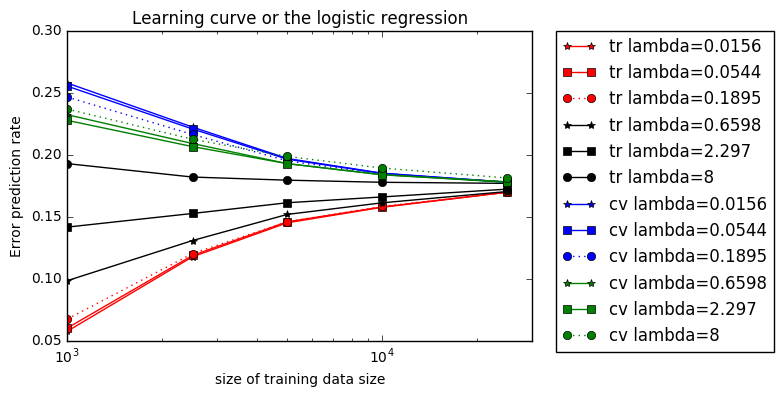

In [512]:

accus = [accu_1000, accu_2500, accu_5000, accu_10000, accu_25000]
sizes = [1000, 2500,5000,10000, 25000]
trs = []
cvs = []
for accu_ in accus:
    tr_accs = [np.array(i[0]) for i in accu_]
    cv_accs = [np.array(i[1]) for i in accu_]
    tr_error = [1-np.mean(i) for i in tr_accs]
    cv_error = [1-np.mean(i) for i in cv_accs]
    trs.append(tr_error)
    cvs.append(cv_error)

trs = np.array(trs)
cvs = np.array(cvs)

plt.semilogx(sizes, (trs.T)[0],'r*-', label='tr lambda=0.0156')
plt.semilogx(sizes, (trs.T)[1],'rs-',label='tr lambda=0.0544')
plt.semilogx(sizes, (trs.T)[2],'ro:', label='tr lambda=0.1895')
plt.semilogx(sizes, (trs.T)[3],'k*-', label='tr lambda=0.6598')
plt.semilogx(sizes, (trs.T)[4],'ks-', label='tr lambda=2.297')
plt.semilogx(sizes, (trs.T)[5],'ko-', label='tr lambda=8')

plt.semilogx(sizes, (cvs.T)[0],'b*-', label='cv lambda=0.0156')
plt.semilogx(sizes, (cvs.T)[1],'bs-',label='cv lambda=0.0544')
plt.semilogx(sizes, (cvs.T)[2],'bo:', label='cv lambda=0.1895')
plt.semilogx(sizes, (cvs.T)[3],'g*-', label='cv lambda=0.6598')
plt.semilogx(sizes, (cvs.T)[4],'gs-', label='cv lambda=2.297')
plt.semilogx(sizes, (cvs.T)[5],'go:', label='cv lambda=8')

plt.xlim([10**3, 3*10**4])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Learning curve or the logistic regression")
plt.xlabel("size of training data size")
plt.ylabel("Error prediction rate")
plt.savefig("LearningCurve")
plt.show()

In [ ]:
, sizes, (cvs.T)[0], 'bs-')


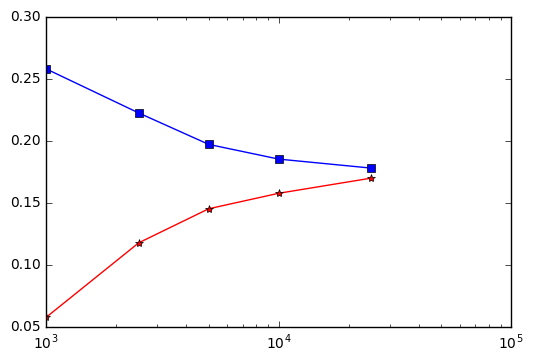

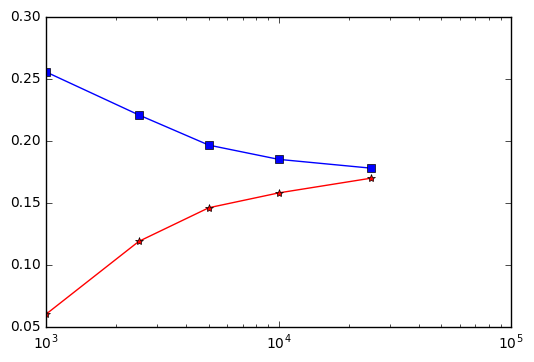

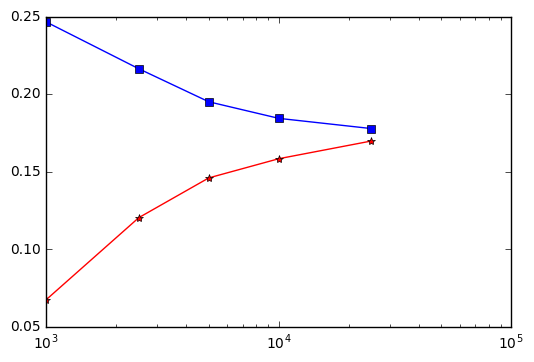

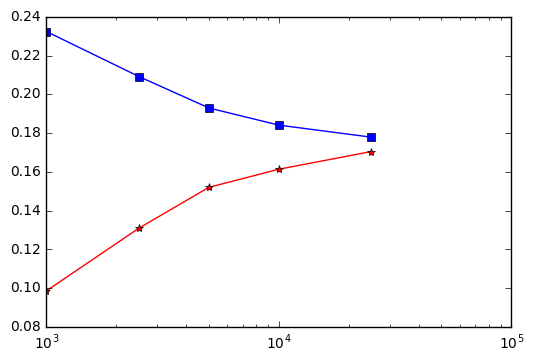

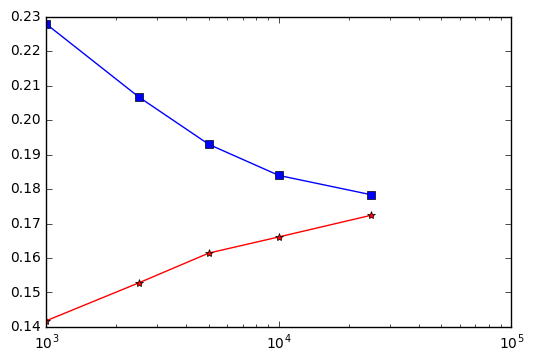

In [489]:
learning_curve([accu_1000, accu_2500, accu_5000, accu_10000, accu_25000],
              np.logspace(-3, 1.5, 6, 4), [1000, 2500,5000,10000, 25000])

processing(accu_1000, np.logspace(-3, 1.5, 6, 4))

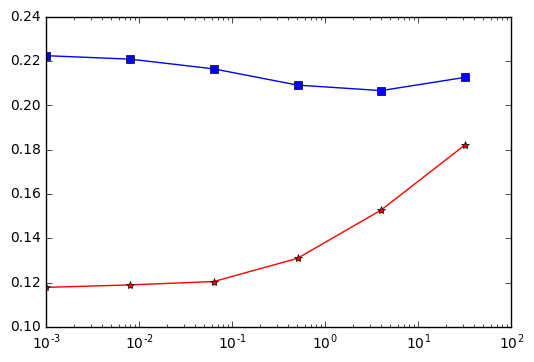

In [484]:
processing(accu_2500, np.logspace(-3, 1.5, 6, 4))

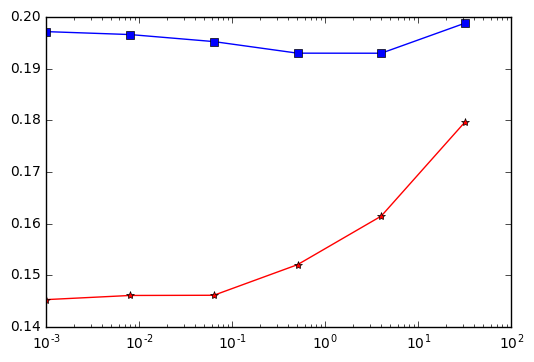

In [485]:
processing(accu_5000, np.logspace(-3, 1.5, 6, 4))

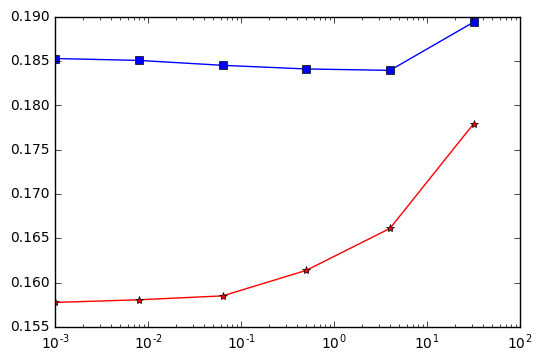

In [486]:
processing(accu_10000, np.logspace(-3, 1.5, 6, 4))

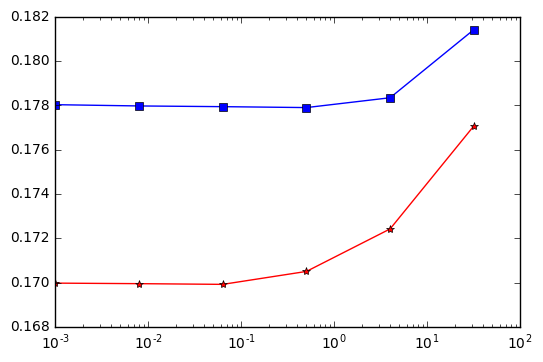

In [487]:
processing(accu_25000, np.logspace(-3, 1.5, 6, 4))

## Ordinary

In [427]:
idxes = np.arange(20000)
cols = np.arange(train_tX9.shape[1])

L = np.linalg.eigvals(train_tX9[idxes][:, cols].T @ train_tX9[idxes][:, cols]).max()
print(np.real(1/L))

lambda_ = 1
w,cost = logistic_AGDR(train_y9[idxes], train_tX9[idxes][:, cols], gamma=np.real(1/L),
                       max_iters = 100000, lambda_=lambda_, regularizor=regularizor_lasso)

y_pred = predict_labels(w, train_tX9[idxes][:, cols])
tr_acc = accuracy(y_pred, transform_y_back(train_y9[idxes]))
y_pred = predict_labels(w, cv_tX9[:, cols])
te_acc = accuracy(y_pred, transform_y_back(cv_y9))
print(lambda_, tr_acc, te_acc)

6.92272838311708e-07
Losgistic Regression(       0/100000): loss= 13558.3986235257
Losgistic Regression(     100/100000): loss= 9015.03859638758
Losgistic Regression(     200/100000): loss= 8564.93889943202
Losgistic Regression(     300/100000): loss= 8347.85518261214
Losgistic Regression(     400/100000): loss= 8223.67747944826
Losgistic Regression(     500/100000): loss= 8144.97019368849
Losgistic Regression(     600/100000): loss= 8091.40659649746
Losgistic Regression(     700/100000): loss= 8052.09745046569
Losgistic Regression(     800/100000): loss= 8023.83028131998
Losgistic Regression(     900/100000): loss= 8001.74640004757
Losgistic Regression(    1000/100000): loss= 7984.34061861021
Losgistic Regression(    1100/100000): loss= 7971.13626974165
Losgistic Regression(    1200/100000): loss= 7961.27649743662
Losgistic Regression(    1300/100000): loss= 7953.50760543862
Losgistic Regression(    1400/100000): loss= 7949.1291842453
Losgistic Regression(    1500/100000): loss= 7947.

In [428]:
y_pred = predict_labels(w, train_tX9[30000:][:, cols])
acc = accuracy(y_pred, transform_y_back(train_y9[30000:]))
acc

0.81706153846153851

IndexError: tuple index out of range

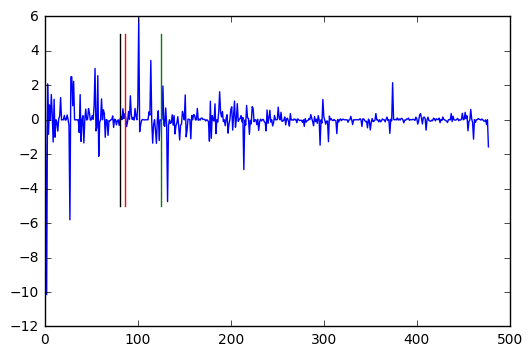

In [424]:
plt.plot(w)

plt.plot([poly_tX.shape[1], poly_tX.shape[1]], [-5, 5], 'k-')
plt.plot([poly_tX.shape[1]+decomposed_tX.shape[1], poly_tX.shape[1]+decomposed_tX.shape[1]], [-5, 5], 'r-')
plt.plot([poly_tX.shape[1]+decomposed_tX.shape[1] + log_poly_tX.shape[1], 
          poly_tX.shape[1]+decomposed_tX.shape[1] + log_poly_tX.shape[1]], [-5, 5], 'g-')
plt.plot([poly_tX.shape[1]+decomposed_tX.shape[1] + log_poly_tX.shape[1] + missing_indicator_tX.shape[1], 
          poly_tX.shape[1]+decomposed_tX.shape[1] + log_poly_tX.shape[1] + missing_indicator_tX.shape[1]],
         [-5, 5], 'r--')
# plt.plot([poly_tX.shape[1]+decomposed_tX.shape[1] + log_poly_tX.shape[1] + missing_indicator_tX.shape[1] + inv_poly_tX.shape[1], 
#           poly_tX.shape[1]+decomposed_tX.shape[1] + log_poly_tX.shape[1] + missing_indicator_tX.shape[1] + inv_poly_tX.shape[1]],
#          [-5, 5], 'k--')
# plt.plot([poly_tX.shape[1]+decomposed_tX.shape[1] + log_poly_tX.shape[1] 
#           + missing_indicator_tX.shape[1] + inv_poly_tX.shape[1]
#           + mixed_tX.shape[1], 
#           poly_tX.shape[1]+decomposed_tX.shape[1] + log_poly_tX.shape[1] 
#           + missing_indicator_tX.shape[1] + inv_poly_tX.shape[1]
#           + mixed_tX.shape[1]], [-5, 5], 'r:')
plt.show()

In [124]:
len(w_cached)

529

#### Choose features that is useful

In [139]:
feature_columns = np.arange(len(w_cached))[abs(w_cached) < 0.025]
feature_columns

array([  8,   9,  12,  14,  15,  16,  23,  26,  52,  58,  65,  69,  75,
        76,  77,  84,  88,  98, 106, 107, 108, 112, 114, 117, 123, 124,
       136, 138, 142, 143, 144, 150, 151, 155, 156, 162, 169, 170, 171,
       173, 175, 189, 202, 205, 210, 214, 222, 225, 226, 227, 228, 231,
       241, 247, 256, 260, 270, 282, 287, 289, 309, 315, 322, 323, 326,
       333, 342, 345, 346, 349, 351, 358, 366, 367, 368, 369, 371, 373,
       376, 379, 383, 384, 386, 387, 391, 403, 404, 407, 416, 418, 421,
       423, 424, 434, 442, 443, 447, 448, 453, 458, 462, 465, 466, 467,
       469, 471, 480, 481, 487, 494, 497, 498, 502, 513, 516, 519, 520,
       521, 523, 524, 525])

In [140]:
feature_columns.shape

(121,)

In [145]:
train_tX9.shape

(225000, 529)

In [147]:
np.linalg.matrix_rank(train_tX9[:10000])

517

In [170]:
np.min(np.max(cov))

nan

In [155]:
cov.shape

(5000, 5000)

In [165]:
cov[abs(cov)>0.99].shape

(5002,)

In [141]:
idxes = np.arange(10000)
cols  = feature_columns

L     = np.linalg.eigvals(train_tX9[idxes][:, cols].T @ train_tX9[idxes][:, cols]).max()
print(np.real(1/L))

lambda_ = 1
w,cost = logistic_AGDR(train_y9[idxes], train_tX9[idxes][:, cols], gamma=np.real(1/L),
                       max_iters = 100000, lambda_=lambda_, regularizor=regularizor_lasso)

y_pred = predict_labels(w, train_tX9[idxes][:, cols])
tr_acc = accuracy(y_pred, transform_y_back(train_y9[idxes]))
y_pred = predict_labels(w, cv_tX9[:, cols])
te_acc = accuracy(y_pred, transform_y_back(cv_y9))
y_pred = predict_labels(w, train_tX9[20000:][:, cols])
acc = accuracy(y_pred, transform_y_back(train_y9[20000:]))
print(lambda_, tr_acc, te_acc, acc)

4.7532857516227975e-06
Losgistic Regression(       0/100000): loss= 44027.643871765
Losgistic Regression(     100/100000): loss= 7149.23068313139
Losgistic Regression(     200/100000): loss= 5830.61785617616
Losgistic Regression(     300/100000): loss= 5651.0690221374
Losgistic Regression(     400/100000): loss= 5610.96407601787
Losgistic Regression(     500/100000): loss= 5584.15653210648
Losgistic Regression(     600/100000): loss= 5565.44509463008
Losgistic Regression(     700/100000): loss= 5554.08864337397
Losgistic Regression(     800/100000): loss= 5550.08004866419
Losgistic Regression(     900/100000): loss= 5548.08541955738
Losgistic Regression(    1000/100000): loss= 5546.07400213894
Losgistic Regression(    1100/100000): loss= 5544.52349151197
Losgistic Regression(    1200/100000): loss= 5543.66170086858
Losgistic Regression(    1300/100000): loss= 5542.96201864574
Losgistic Regression(    1400/100000): loss= 5542.35387058249
Losgistic Regression(    1500/100000): loss= 5541

KeyboardInterrupt: 

## Best lambda for a degree 5 

## Best Results ever

In [882]:
idxes = np.arange(10000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y7[idxes], train_tX7[idxes], gamma=0.0001, 
                   max_iters = 150000, lambda_=0.00001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], cv_tX7, cv_y7, w)
print(tr_acc, te_acc)

6.37656429545e-06
Losgistic Regression(0/150000): loss=6128.661958753694
Losgistic Regression(1000/150000): loss=4382.793973805763
Losgistic Regression(2000/150000): loss=4321.439300698346
Losgistic Regression(3000/150000): loss=4291.208251980238
Losgistic Regression(4000/150000): loss=4270.574245773539
Losgistic Regression(5000/150000): loss=4255.255208797125
Losgistic Regression(6000/150000): loss=4244.187346417512
Losgistic Regression(7000/150000): loss=4236.342382593083
Losgistic Regression(8000/150000): loss=4229.2149455352765
Losgistic Regression(9000/150000): loss=4222.549848793302
Losgistic Regression(10000/150000): loss=4216.256821112506
Losgistic Regression(11000/150000): loss=4210.280363793595
Losgistic Regression(12000/150000): loss=4204.581620909371
Losgistic Regression(13000/150000): loss=4199.130612876477
Losgistic Regression(14000/150000): loss=4193.902700925177
Losgistic Regression(15000/150000): loss=4188.876869375156
Losgistic Regression(16000/150000): loss=4184.0348

In [902]:
idxes = np.arange(20000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)

w_agdr = logistic_AGDR(train_y7[idxes], train_tX7[idxes], gamma=1/L, 
                   max_iters = 150000, lambda_=0.00001, regularizor=regularizor_lasso, w0=w_agdr)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], 
                                         cv_tX7, cv_y7, w_agdr)
print(tr_acc, te_acc)

2.79002650416e-06
Losgistic Regression(0/150000): loss=7981.108636380177
Losgistic Regression(100/150000): loss=7981.110107054736
0.00147067455873
Totoal number of iterations =  100
Loss =  7981.11010705
0.8212 0.8158


# Cross Validation

In [69]:
set_up_f = lambda y, tx : logistic_AGDR(y, tx, gamma=1e-6, 
               max_iters = 10000, lambda_=0.5, regularizor=regularizor_lasso)

cross_validation_var(y9, tX9, 
                     K=25, 
                     func=set_up_f, 
                     seed=3, 
                     fpred=predict_cv,
                     faccuracy=accuracy,
                     max_fold=1
                    )

NameError: name 'cross_validation_var' is not defined

# test

## Generate predictions and save ouput in csv format for submission:

In [19]:
DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [316]:
filled_test_tX_median = fill_na(tX_test, np.median)
#
log_test_tX               = logs_of_features(filled_test_tX_median, Features_using_log)
decomposed_test_tX        = decompose_categorical_features(tX_test)
missing_indicator_test_tX = missing_indicator(tX_test)
inverse_test_tX           = inver_terms(filled_test_tX_median, Features_using_log)
mixed_test_tX             = mixed_features(filled_test_tX_median, Features_non_categorical)
# mixed_invese_test_tX      = mixed_inverse_features(filled_test_tX_median, Features_denominate, Features_numerator)

In [317]:
## Change
# * filled_test_tX_median
# * w
# * mean_x, std_x
# * degree
##############################
# For non categorical features, build polynomials
poly_test_tX     = build_polynomial_without_mixed_term(filled_test_tX_median[:, Features_non_categorical], degree=degree)
log_poly_test_tX = build_polynomial_without_mixed_term(log_test_tX, degree=degree)
inv_poly_test_tX = build_polynomial_without_mixed_term(inverse_test_tX, degree=degree)

In [354]:
# Build a design matrix
design_matrix_test = np.c_[poly_test_tX, decomposed_test_tX, missing_indicator_test_tX, log_poly_test_tX, 
                           mixed_test_tX]

In [357]:
test_tX, _, _ = standardize(design_matrix_test, mean_x, std_x)
print(test_tX.shape)

(568238, 478)


In [359]:
y0 = predict_labels(weights=w, data=test_tX)

In [358]:
y1 = y0
y1

array([-1., -1., -1., ..., -1., -1., -1.])

In [363]:
np.mean(abs(y1 - y0))

0.62168668762032808

In [364]:
OUTPUT_PATH = '../results/result12.csv' # TODO: fill in desired name of output file for submission
create_csv_submission(ids_test, y0, OUTPUT_PATH)

In [31]:
import pandas as pd

In [32]:
predt_11 = pd.read_csv('../results/result11.csv')
predt_10 = pd.read_csv('../results/result10.csv')

In [40]:
predt_9  = pd.read_csv('../results/result9.csv')

In [53]:
(predt_11['Prediction'] == series).value_counts()

True     485635
False     82603
dtype: int64

In [51]:
series = pd.Series(y0)